# Предобработка данных

Итак, перед нами задача классификации временных рядов. Начнём с того, что прочтём файл с тренировочными данными

In [89]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_parquet('train.parquet')
df
Начнём предобработку - удалим столбец 'id' - он явно не понадобится для обучения модели
df = df.drop('id', axis=1)
Функция listToTimeLine возвращает датафрейм - временной ряд
def listToTimeLine(dates, values):
  df = pd.DataFrame({'dates': dates[0], 'values': values[0]})
  return df

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


Начнём предобработку - удалим столбец 'id' - он явно не понадобится для обучения модели

In [90]:
df = df.drop('id', axis=1)

Функция listToTimeLine возвращает датафрейм - временной ряд

In [91]:
def listToTimeLine(dates, values):
  df = pd.DataFrame({'dates': dates[0], 'values': values[0]})
  return df

Функция iteratingTimeSeries возвращает i-тую датафрейм-временной ряд в большом датафрейме

In [92]:
def iteratingTimeSeries(i, df):
  df_np = np.array(df)[i]
  df_i = pd.DataFrame(df_np).T

  return listToTimeLine(df_i[0], df_i[1])

Визуализируем несколько рядов

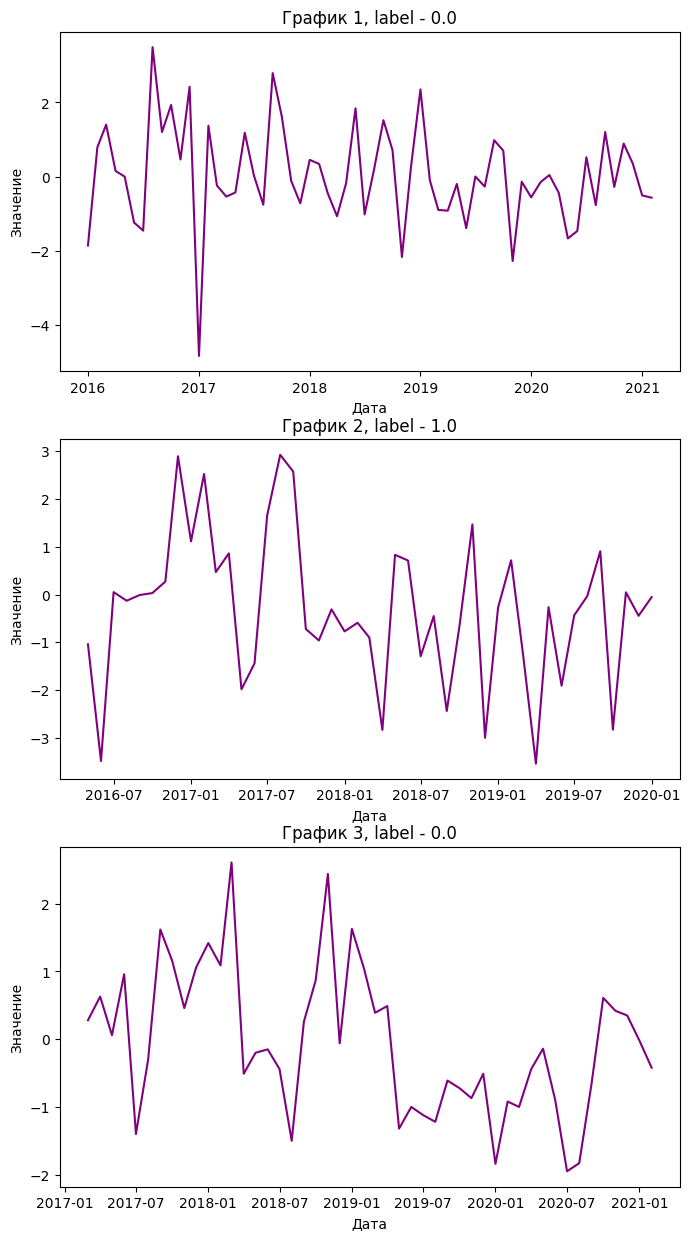

In [93]:
fig, axes = plt.subplots(3, 1, figsize = (8, 15))
for i in range(3):
  a = iteratingTimeSeries(i, df)
  axes[i].plot_date(a['dates'], a['values'], 'purple')
  label_i = df['label'].loc[i]
  axes[i].set_title(f'График {i+1}, label - {label_i}')
  axes[i].set_xlabel('Дата')
  axes[i].set_ylabel('Значение')

Для анализа временного ряда и предсказания принадлежности его к классу нужны признаки - предлагается идея декомпозирования временного ряда с помощью библиотеки statsmodels (реализовано в функции getDfComposed)

In [94]:
import statsmodels.tsa.seasonal
def getDfComposed(df):
  return statsmodels.tsa.seasonal.seasonal_decompose(df, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=10)

Дальше происходит обработка данных для возможности дальнейшей работы с ними

Можно не запускать этот участок кода, так как обработка всего тренировочного датасета ввиду его размера занимает много времени, обработанный датасет уже хранится в файле 'train_features (1).csv', можно сразу прочесть его (блок кода двумя ячейками ниже)

In [ ]:
df_features = pd.DataFrame(columns = ['observed', 'seasonal', 'trend', 'resid', 'weights'])
for i in range(len(df)):
  df_i = iteratingTimeSeries(i, df)

  df_transformed = pd.DataFrame(data=np.array(df_i['values']), index = pd.to_datetime(np.array(df_i['dates'])), columns = ['values']).fillna(0)
  df_composed = getDfComposed(df_transformed)
  features = [df_composed.observed.mean(), df_composed.seasonal.mean(), df_composed.trend.mean(), df_composed.resid.mean(), df_composed.weights.mean()]
  df_features.loc[len(df_features)] = features

df_features

In [ ]:
df_features.to_csv('train_features.csv', index=False)

In [105]:
df_features = pd.read_csv('train_features (1).csv')
df_features = df_features.drop('weights', axis=1)
df_features

,observed,seasonal,trend,resid
0,0.023710,-1.095428e-02,0.035775,-0.001111
1,-0.310777,1.470799e-02,-0.240379,-0.085106
2,-0.046042,4.625929e-18,-0.043362,-0.002680
3,-0.130000,-5.088522e-17,-0.058675,-0.071325
4,-0.270536,1.280007e-02,-0.270844,-0.012492
...,...,...,...,...
79995,0.163818,-2.822373e-02,0.152274,0.039768
79996,-0.112555,-4.325337e-02,-0.087003,0.017702
79997,-0.201373,-2.901209e-02,-0.177542,0.005181
79998,-0.075397,-1.936019e-02,-0.129483,0.073447


После обработки данных получили таблицу с 4 признаками для каждого временного ряда

# Анализ данных (EDA)

Визуализируем соотношения признаков с признаком 'observed'

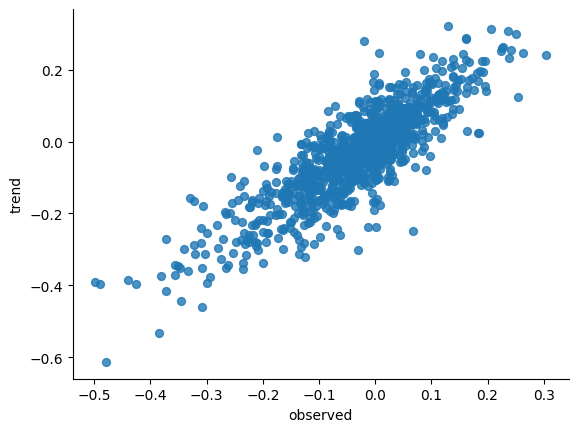

In [119]:
# @title observed vs trend
df_features[:1000].plot(kind='scatter', x='observed', y='trend', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Похоже, что между признаками 'observed' и 'trend' есть какая-то линейная зависимость

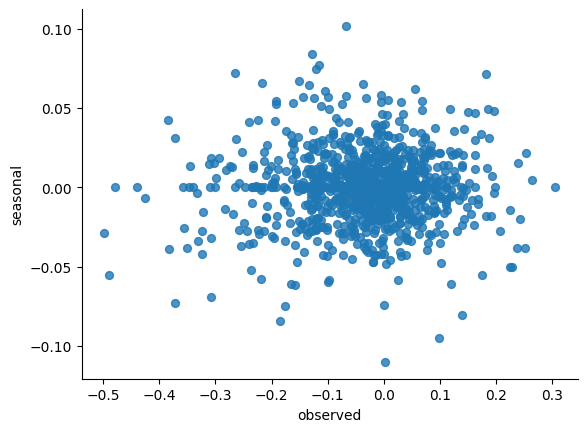

In [120]:
# @title observed vs seasonal
df_features[:1000].plot(kind='scatter', x='observed', y='seasonal', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

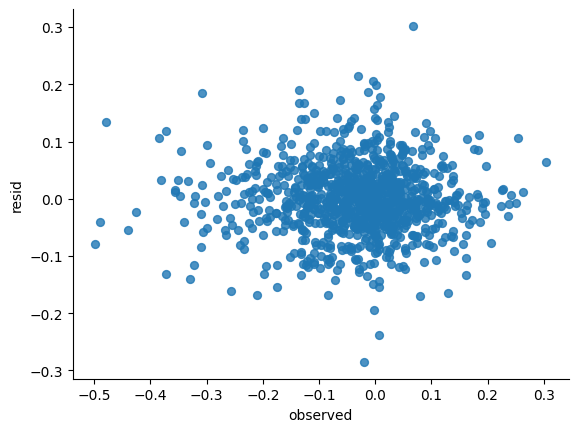

In [121]:
# @title observed vs resid
df_features[:1000].plot(kind='scatter', x='observed', y='resid', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Посмотрим на распределение данных

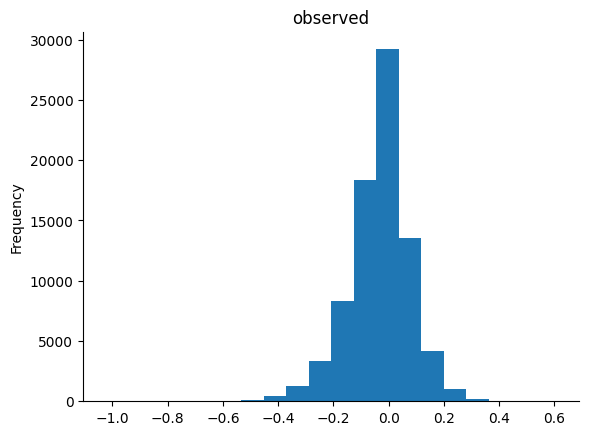

In [97]:
df_features['observed'].plot(kind='hist', bins=20, title='observed')
plt.gca().spines[['top', 'right',]].set_visible(False)

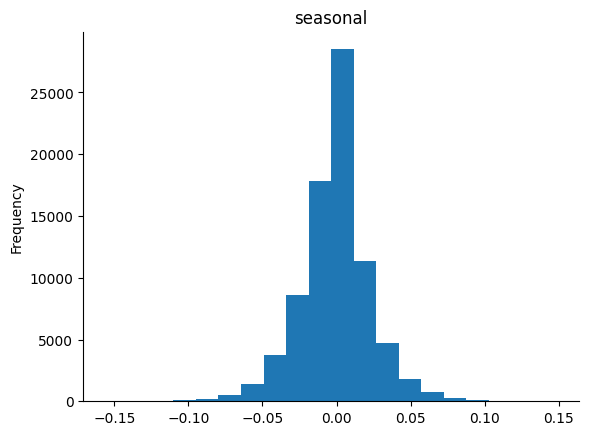

In [99]:
df_features['seasonal'].plot(kind='hist', bins=20, title='seasonal')
plt.gca().spines[['top', 'right',]].set_visible(False)

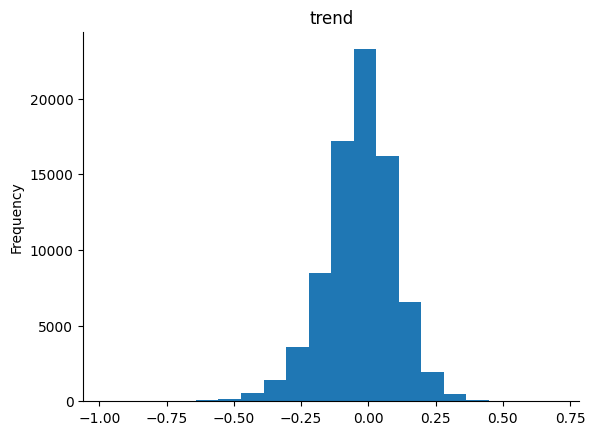

In [101]:
df_features['trend'].plot(kind='hist', bins=20, title='trend')
plt.gca().spines[['top', 'right',]].set_visible(False)

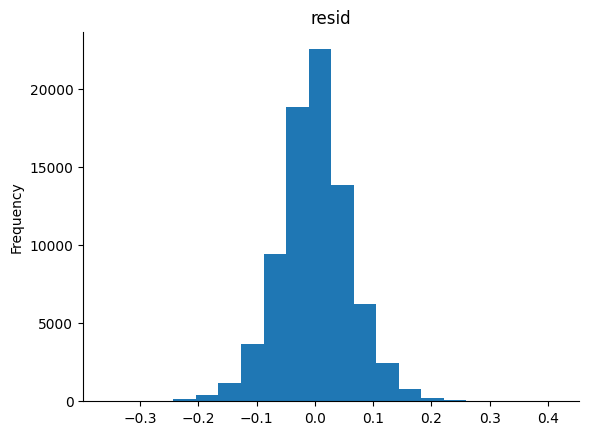

In [103]:
df_features['resid'].plot(kind='hist', bins=20, title='resid')
plt.gca().spines[['top', 'right',]].set_visible(False)

Все признаки имеют нормальное/близкое к нормальному распределению, причём большинство значений колеблятся около нуля

Посмотрим на heatmap корреляции признаков между собой:

<Axes: >

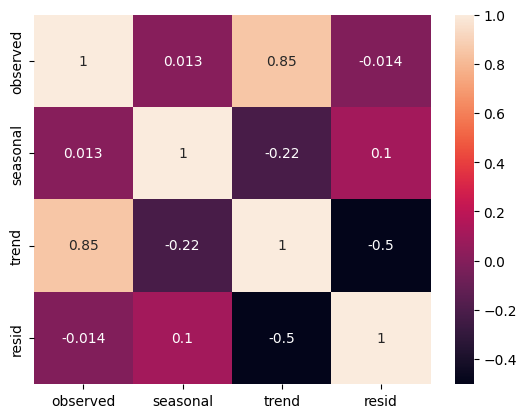

In [ ]:
sns.heatmap(df_features.corr(), annot=True)

'trend' сильно коррелирует с 'observed' и 'resid'


Дообрабатываем данные и проведём FeatureEngineering

In [106]:
df_features['label'] = df['label']
df_features = df_features[df_features['observed'] != 0]
df_features = df_features[df_features['seasonal'] != 0]
df_features = df_features[df_features['trend'] != 0]
df_features = df_features[df_features['resid'] != 0]
df_features

,observed,seasonal,trend,resid,label
0,0.023710,-1.095428e-02,0.035775,-0.001111,0.0
1,-0.310777,1.470799e-02,-0.240379,-0.085106,1.0
2,-0.046042,4.625929e-18,-0.043362,-0.002680,0.0
3,-0.130000,-5.088522e-17,-0.058675,-0.071325,0.0
4,-0.270536,1.280007e-02,-0.270844,-0.012492,0.0
...,...,...,...,...,...
79995,0.163818,-2.822373e-02,0.152274,0.039768,0.0
79996,-0.112555,-4.325337e-02,-0.087003,0.017702,1.0
79997,-0.201373,-2.901209e-02,-0.177542,0.005181,0.0
79998,-0.075397,-1.936019e-02,-0.129483,0.073447,0.0


Добавим новый признак и изменим 'trend'

In [107]:
X = df_features
y = X['label']
X = X.drop('label', axis=1)
window_size = 5
X['rolling_std'] = X['observed'].rolling(window=window_size).std()
X['trend'] = (np.array(X['trend']) / np .array(np.abs(X['trend']))) * np.log(np.abs(X['trend'])**2)
X['rolling_std'] = X['rolling_std'].fillna(X['rolling_std'].mean())
X

,observed,seasonal,trend,resid,rolling_std
0,0.023710,-1.095428e-02,-6.661036,-0.001111,0.100720
1,-0.310777,1.470799e-02,2.851078,-0.085106,0.100720
2,-0.046042,4.625929e-18,6.276352,-0.002680,0.100720
3,-0.130000,-5.088522e-17,5.671485,-0.071325,0.100720
4,-0.270536,1.280007e-02,2.612424,-0.012492,0.142922
...,...,...,...,...,...
79995,0.163818,-2.822373e-02,-3.764150,0.039768,0.096971
79996,-0.112555,-4.325337e-02,4.883614,0.017702,0.105495
79997,-0.201373,-2.901209e-02,3.457102,0.005181,0.143239
79998,-0.075397,-1.936019e-02,4.088409,0.073447,0.135456


<Axes: >

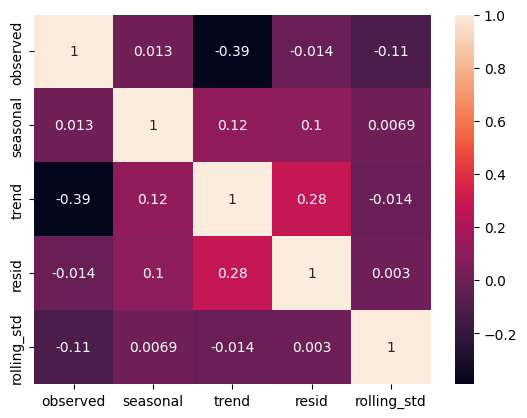

In [108]:
sns.heatmap(X.corr(), annot=True)

Больше сильной корреляции между признаками не наблюдается

Визуализируем данные относительно бинарной классификации, где оси X, Y - преобразованные с помощью библиотеки TSNE данные

<Axes: xlabel='x', ylabel='y'>

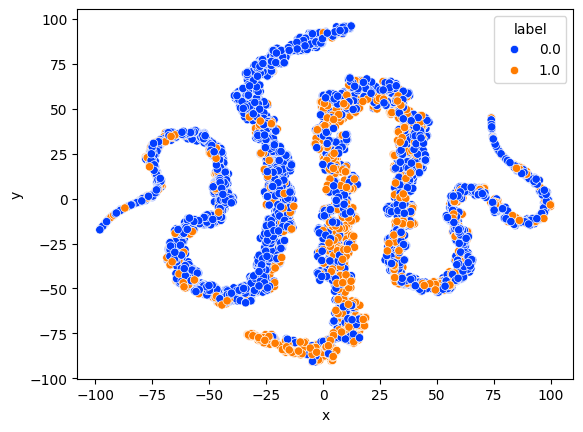

In [ ]:
from sklearn.manifold import TSNE
T = TSNE(n_components=2, perplexity=25, random_state=123)
TSNE_features = T.fit_transform(X[:8000])
DATA = X[:8000].copy()
DATA['x'] = TSNE_features[:, 0]
DATA['y'] = TSNE_features[:, 1]
sns.scatterplot(x='x', y='y', hue=y, data=DATA, palette ='bright')

Никакой явной зависимости не наблюдается

Вроде бы данные разделены на два "кластера", но при этом оба кластера перемешаны объектами разных классов

# Обучение модели

Приступим к обучению модели: разделим данные на тренировочные и валидационные

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
X_copy = X

Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, train_size = 0.7, random_state=42)


Установим библиотеки catboost для использования модели CatBoostClassifier и optuna для более быстрого подбора гиперпараметров

In [ ]:
!pip install catboost
!pip install optuna
from catboost import CatBoostClassifier
import optuna

Подберём гиперпараметр depth с помощью optuna

In [ ]:
def objective(trial):
  depth = trial.suggest_int('depth', 4, 8)

  model = CatBoostClassifier(eval_metric='AUC', depth = depth)
  model.fit(Xtrain, ytrain, eval_set=(Xvalid, yvalid),
    verbose=100,
    early_stopping_rounds = 200)

  ypred = model.predict(Xvalid)
  roc = roc_auc_score(yvalid, ypred)
  return roc

import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 8)

[I 2024-10-23 14:17:40,407] A new study created in memory with name: no-name-91785e2f-195a-4333-a59d-1aa6e34d22f0


Learning rate set to 0.085497
0:	test: 0.7919158	best: 0.7919158 (0)	total: 12.2ms	remaining: 12.2s
100:	test: 0.8106481	best: 0.8106481 (100)	total: 1.41s	remaining: 12.5s
200:	test: 0.8111498	best: 0.8111783 (197)	total: 2.84s	remaining: 11.3s
300:	test: 0.8108517	best: 0.8112024 (233)	total: 5.73s	remaining: 13.3s
400:	test: 0.8105339	best: 0.8112024 (233)	total: 7.63s	remaining: 11.4s


[I 2024-10-23 14:17:48,704] Trial 0 finished with value: 0.6673997417925619 and parameters: {'depth': 4}. Best is trial 0 with value: 0.6673997417925619.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8112024268
bestIteration = 233

Shrink model to first 234 iterations.
Learning rate set to 0.085497
0:	test: 0.7919158	best: 0.7919158 (0)	total: 12.1ms	remaining: 12s
100:	test: 0.8106481	best: 0.8106481 (100)	total: 1.39s	remaining: 12.4s
200:	test: 0.8111498	best: 0.8111783 (197)	total: 2.82s	remaining: 11.2s
300:	test: 0.8108517	best: 0.8112024 (233)	total: 4.22s	remaining: 9.79s
400:	test: 0.8105339	best: 0.8112024 (233)	total: 5.62s	remaining: 8.39s


[I 2024-10-23 14:17:54,986] Trial 1 finished with value: 0.6673997417925619 and parameters: {'depth': 4}. Best is trial 0 with value: 0.6673997417925619.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8112024268
bestIteration = 233

Shrink model to first 234 iterations.
Learning rate set to 0.085497
0:	test: 0.7925259	best: 0.7925259 (0)	total: 15.6ms	remaining: 15.6s
100:	test: 0.8108842	best: 0.8109464 (91)	total: 1.55s	remaining: 13.8s
200:	test: 0.8111220	best: 0.8113337 (145)	total: 4.29s	remaining: 17s
300:	test: 0.8106014	best: 0.8113337 (145)	total: 6.67s	remaining: 15.5s


[I 2024-10-23 14:18:02,528] Trial 2 finished with value: 0.6672938258570649 and parameters: {'depth': 5}. Best is trial 0 with value: 0.6673997417925619.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8113337113
bestIteration = 145

Shrink model to first 146 iterations.
Learning rate set to 0.085497
0:	test: 0.7919158	best: 0.7919158 (0)	total: 13.1ms	remaining: 13.1s
100:	test: 0.8106481	best: 0.8106481 (100)	total: 1.4s	remaining: 12.5s
200:	test: 0.8111498	best: 0.8111783 (197)	total: 2.79s	remaining: 11.1s
300:	test: 0.8108517	best: 0.8112024 (233)	total: 4.2s	remaining: 9.76s
400:	test: 0.8105339	best: 0.8112024 (233)	total: 5.64s	remaining: 8.42s


[I 2024-10-23 14:18:08,817] Trial 3 finished with value: 0.6673997417925619 and parameters: {'depth': 4}. Best is trial 0 with value: 0.6673997417925619.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8112024268
bestIteration = 233

Shrink model to first 234 iterations.
Learning rate set to 0.085497
0:	test: 0.7962213	best: 0.7962213 (0)	total: 18.1ms	remaining: 18.1s
100:	test: 0.8114570	best: 0.8115645 (97)	total: 1.71s	remaining: 15.3s
200:	test: 0.8112908	best: 0.8115716 (112)	total: 5.18s	remaining: 20.6s
300:	test: 0.8106130	best: 0.8115716 (112)	total: 7.13s	remaining: 16.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8115716213


[I 2024-10-23 14:18:16,316] Trial 4 finished with value: 0.6678911176122649 and parameters: {'depth': 6}. Best is trial 4 with value: 0.6678911176122649.


bestIteration = 112

Shrink model to first 113 iterations.
Learning rate set to 0.085497
0:	test: 0.7987865	best: 0.7987865 (0)	total: 23.5ms	remaining: 23.5s
100:	test: 0.8105426	best: 0.8106906 (93)	total: 2.34s	remaining: 20.8s
200:	test: 0.8093505	best: 0.8106906 (93)	total: 4.65s	remaining: 18.5s


[I 2024-10-23 14:18:23,272] Trial 5 finished with value: 0.6657890950095292 and parameters: {'depth': 8}. Best is trial 4 with value: 0.6678911176122649.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8106905977
bestIteration = 93

Shrink model to first 94 iterations.
Learning rate set to 0.085497
0:	test: 0.7962213	best: 0.7962213 (0)	total: 15.3ms	remaining: 15.3s
100:	test: 0.8114570	best: 0.8115645 (97)	total: 2.38s	remaining: 21.2s
200:	test: 0.8112908	best: 0.8115716 (112)	total: 5.32s	remaining: 21.1s
300:	test: 0.8106130	best: 0.8115716 (112)	total: 7.03s	remaining: 16.3s


[I 2024-10-23 14:18:30,673] Trial 6 finished with value: 0.6678911176122649 and parameters: {'depth': 6}. Best is trial 4 with value: 0.6678911176122649.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8115716213
bestIteration = 112

Shrink model to first 113 iterations.
Learning rate set to 0.085497
0:	test: 0.7962213	best: 0.7962213 (0)	total: 15.1ms	remaining: 15s
100:	test: 0.8114570	best: 0.8115645 (97)	total: 1.71s	remaining: 15.2s
200:	test: 0.8112908	best: 0.8115716 (112)	total: 3.4s	remaining: 13.5s
300:	test: 0.8106130	best: 0.8115716 (112)	total: 5.1s	remaining: 11.8s


[I 2024-10-23 14:18:36,149] Trial 7 finished with value: 0.6678911176122649 and parameters: {'depth': 6}. Best is trial 4 with value: 0.6678911176122649.


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8115716213
bestIteration = 112

Shrink model to first 113 iterations.


In [ ]:
print(study.best_params)

{'depth': 6}


Лучшее значение гиперпараметра depth - 6, передадим его при объявлении модели

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    eval_metric='AUC',
    depth = 6
    #logging_level='Silent',
)

Обучим модель

In [ ]:
model.fit(
    Xtrain, ytrain,
    eval_set=(Xvalid, yvalid),
    verbose=100,
    early_stopping_rounds = 200
)

Learning rate set to 0.085497
0:	test: 0.7962213	best: 0.7962213 (0)	total: 16ms	remaining: 16s
100:	test: 0.8114570	best: 0.8115645 (97)	total: 1.78s	remaining: 15.8s
200:	test: 0.8112908	best: 0.8115716 (112)	total: 3.46s	remaining: 13.8s
300:	test: 0.8106130	best: 0.8115716 (112)	total: 5.13s	remaining: 11.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8115716213
bestIteration = 112

Shrink model to first 113 iterations.


In [ ]:
cat_pred = model.predict_proba(Xvalid)[:, 1]
print(roc_auc_score(yvalid, cat_pred))

0.8115716212860383


Получившаяся roc_auc метрика на одном из разделений - 0.812

Посмотрим на корреляцию признаков относительно работы модели для бинарной классификации

In [ ]:
feature_importances = model.get_feature_importance()
feature_names = X_copy.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

observed: 66.98143174972914
seasonal: 9.977116409345282
trend: 9.384172059442992
resid: 8.528731284864573
rolling_std: 5.128548496618022


Оценим результат работы модели на кросс-валидации на пяти фолдах

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc', verbose=0)

In [ ]:
print("Средняя точность модели (кросс-валидация):", scores.mean())

Средняя точность модели (кросс-валидация): 0.8058499127252912


Результат довольно близок к метрике на одном разбиении

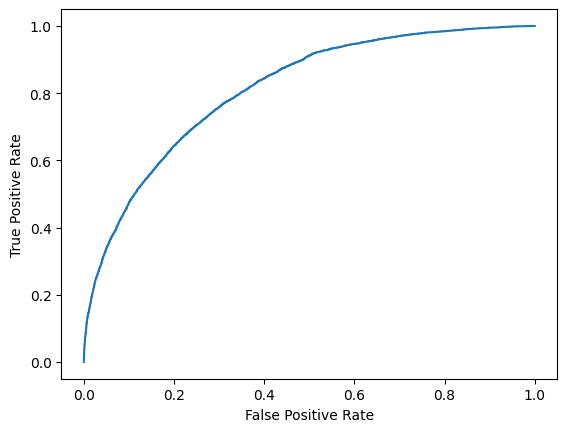

In [ ]:
# построение ROC кривой
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(yvalid, cat_pred)
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Сохраним модель

In [ ]:
from joblib import dump, load
dump(model, 'model.joblib')

['model.joblib']

# Предсказание на тестовых данных

Дальше идёт всё то же самое, что было сделано на тренировочных данных, только для того, чтобы сделать предсказание на тестовых

In [ ]:
clf = load('model.joblib')

In [ ]:
df_test = pd.read_parquet('test.parquet')
df_test

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."
...,...,...,...
19995,80341,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[3.01, -0.58, 1.55, 0.48, -0.35, 1.93, 3.86, 2..."
19996,5891,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[0.66, 1.3, 2.78, -0.25, -1.97, -0.55, -1.08, ..."
19997,29091,"[2017-01-01, 2017-02-01, 2017-03-01, 2017-04-0...","[0.09, 0.44, 1.55, 0.15, 0.3, 0.19, 0.34, 1.05..."
19998,85877,"[2017-04-01, 2017-05-01, 2017-06-01, 2017-07-0...","[0.28, 1.92, 1.14, 2.4, 1.46, 1.08, -0.12, 0.6..."


In [ ]:
test_id = df_test['id']
df_test = df_test.drop('id', axis=1)

In [ ]:
df_features_test = pd.DataFrame(columns = ['observed', 'seasonal', 'trend', 'resid', 'weights'])
for i in range(len(df_test)):
  df_i = iteratingTimeSeries(i, df_test)
  df_transformed = pd.DataFrame(data=np.array(df_i['values']), index = pd.to_datetime(np.array(df_i['dates'])), columns = ['values']).fillna(0)
  df_composed = getDfComposed(df_transformed)
  features = [df_composed.observed.mean(), df_composed.seasonal.mean(), df_composed.trend.mean(), df_composed.resid.mean(), df_composed.weights.mean()]
  df_features_test.loc[len(df_features_test)] = features

df_features_test

,observed,seasonal,trend,resid,weights
0,0.037895,-0.036967,0.048936,0.025926,1.0
1,-0.016909,-0.022426,-0.035939,0.041456,1.0
2,-0.039569,-0.030259,0.062260,-0.071570,1.0
3,0.159231,-0.009765,0.159546,0.009451,1.0
4,-0.094705,-0.005538,0.025234,-0.114401,1.0
...,...,...,...,...,...
19995,-0.022217,0.004058,0.015707,-0.041982,1.0
19996,0.072439,-0.022101,0.071216,0.023324,1.0
19997,0.068727,0.004505,0.134248,-0.070026,1.0
19998,-0.037175,0.004739,-0.016433,-0.025480,1.0


In [ ]:
df_features_test.to_csv('df_features_test.csv', index=False)

In [ ]:
test_features = pd.read_csv('df_features_test.csv')
test_features

,observed,seasonal,trend,resid,weights
0,0.037895,-0.036967,0.048936,0.025926,1.0
1,-0.016909,-0.022426,-0.035939,0.041456,1.0
2,-0.039569,-0.030259,0.062260,-0.071570,1.0
3,0.159231,-0.009765,0.159546,0.009451,1.0
4,-0.094705,-0.005538,0.025234,-0.114401,1.0
...,...,...,...,...,...
19995,-0.022217,0.004058,0.015707,-0.041982,1.0
19996,0.072439,-0.022101,0.071216,0.023324,1.0
19997,0.068727,0.004505,0.134248,-0.070026,1.0
19998,-0.037175,0.004739,-0.016433,-0.025480,1.0


In [ ]:
X_test = test_features.drop('weights', axis=1)
window_size = 5
X_test['rolling_std'] = X_test['observed'].rolling(window=window_size).std()
X_test['trend'] = (np.array(X_test['trend']) / np.array(np.abs(X_test['trend']))) * np.log(np.abs(X_test['trend'])**2)
X_test['rolling_std'] = X_test['rolling_std'].fillna(X_test['rolling_std'].mean())
X_test

<ipython-input-79-16ccc1e281d2>:4: RuntimeWarning: invalid value encountered in divide
  X_test['trend'] = (np.array(X_test['trend']) / np.array(np.abs(X_test['trend']))) * np.log(np.abs(X_test['trend'])**2)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,observed,seasonal,trend,resid,rolling_std
0,0.037895,-0.036967,-6.034492,0.025926,0.101106
1,-0.016909,-0.022426,6.651858,0.041456,0.101106
2,-0.039569,-0.030259,-5.552885,-0.071570,0.101106
3,0.159231,-0.009765,-3.670850,0.009451,0.101106
4,-0.094705,-0.005538,-7.359155,-0.114401,0.096422
...,...,...,...,...,...
19995,-0.022217,0.004058,-8.307277,-0.041982,0.127167
19996,0.072439,-0.022101,-5.284069,0.023324,0.125177
19997,0.068727,0.004505,-4.016137,-0.070026,0.126885
19998,-0.037175,0.004739,8.216905,-0.025480,0.084071


In [ ]:
final_pred = clf.predict_proba(X_test)[:, 1]
submission = pd.DataFrame({'id': test_id, 'score': final_pred})
submission

,id,score
0,6125,0.067450
1,26781,0.212447
2,13333,0.308712
3,53218,0.024642
4,84204,0.475419
...,...,...
19995,80341,0.230051
19996,5891,0.050239
19997,29091,0.067916
19998,85877,0.278292


Сохраним получившиеся предсказания

In [ ]:
submission.to_csv('submission.csv', index=False)